In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/user_level_master.csv")
df.head()

,user_id,country,subscription_plan,subscription_start_date,monthly_spend,is_active,primary_device,created_at,total_watches,active_days,last_watch_date,total_reviews,avg_rating,total_searches,last_search_date,total_recommendations
0,user_00001,USA,Basic,2024-04-08,36.06,1,Laptop,2023-04-01 14:40:50.540242,13,12,2025-10-30,1.0,4.000000,1.0,2024-12-29,3.0
1,user_00002,USA,Premium+,2024-05-24,14.59,1,Desktop,2024-10-10 15:39:11.030515,15,14,2025-11-28,4.0,3.500000,3.0,2025-12-08,NaN
2,user_00003,USA,Standard,2023-09-22,11.71,0,Desktop,2024-06-29 14:27:49.560875,9,8,2025-06-24,1.0,4.000000,NaN,NaN,6.0
3,user_00004,USA,Standard,2024-08-21,28.56,1,Laptop,2023-04-11 01:01:59.614841,15,14,2025-12-29,4.0,2.250000,2.0,2025-12-29,4.0
4,user_00005,USA,Standard,2024-10-28,9.54,1,Desktop,2025-04-12 19:59:30.137806,10,9,2025-09-19,3.0,3.333333,2.0,2025-09-29,1.0


In [3]:
df.isnull().sum().sort_values(ascending=False)

avg_rating                 2312
monthly_spend              1017
last_search_date            839
user_id                       0
subscription_start_date       0
is_active                     0
subscription_plan             0
country                       0
created_at                    0
primary_device                0
total_watches                 0
active_days                   0
total_reviews                 0
last_watch_date               0
total_searches                0
total_recommendations         0
dtype: int64

In [4]:
date_cols = [
    "subscription_start_date",
    "created_at",
    "last_watch_date",
    "last_search_date"
]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

In [5]:
num_cols = [
    "total_watches",
    "active_days",
    "total_reviews",
    "avg_rating",
    "total_searches",
    "total_recommendations",
    "monthly_spend"
]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [6]:
df["total_watches"] = df["total_watches"].fillna(0)
df["active_days"] = df["active_days"].fillna(0)
df["total_reviews"] = df["total_reviews"].fillna(0)
df["total_searches"] = df["total_searches"].fillna(0)
df["total_recommendations"] = df["total_recommendations"].fillna(0)

# Ratings: use mean (neutral behaviour)
df["avg_rating"] = df["avg_rating"].fillna(df["avg_rating"].mean())

# Monthly spend: median is safer than mean
df["monthly_spend"] = df["monthly_spend"].fillna(
    df["monthly_spend"].median()
)


In [7]:
(df.isnull().mean() * 100).round(2)

user_id                    0.00
country                    0.00
subscription_plan          0.00
subscription_start_date    0.00
monthly_spend              0.00
is_active                  0.00
primary_device             0.00
created_at                 0.00
total_watches              0.00
active_days                0.00
last_watch_date            0.00
total_reviews              0.00
avg_rating                 0.00
total_searches             0.00
last_search_date           8.15
total_recommendations      0.00
dtype: float64

In [8]:
numeric_zero_cols = [
    "total_watches",
    "active_days",
    "total_reviews",
    "total_searches",
    "total_recommendations"
]

for col in numeric_zero_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

In [9]:
if "avg_rating" in df.columns:
    df["avg_rating"] = df["avg_rating"].fillna(df["avg_rating"].mean())

In [10]:
if "monthly_spend" in df.columns:
    df["monthly_spend"] = df["monthly_spend"].fillna(
        df["monthly_spend"].median()
    )

In [11]:
categorical_cols = [
    "country",
    "subscription_plan",
    "primary_device",
    "gender"
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

In [12]:
date_cols = [
    "subscription_start_date",
    "created_at",
    "last_watch_date",
    "last_search_date"
]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

In [13]:
from sklearn.ensemble import IsolationForest

iso_features = [
    "total_watches",
    "active_days",
    "total_searches"
]

iso_df = df[iso_features]

iso = IsolationForest(
    contamination=0.01,
    random_state=42
)

df["anomaly_flag"] = iso.fit_predict(iso_df)

# Keep only normal behavior
df = df[df["anomaly_flag"] == 1].drop(columns="anomaly_flag")

In [14]:
df.isnull().sum()

user_id                      0
country                      0
subscription_plan            0
subscription_start_date      0
monthly_spend                0
is_active                    0
primary_device               0
created_at                   0
total_watches                0
active_days                  0
last_watch_date              0
total_reviews                0
avg_rating                   0
total_searches               0
last_search_date           824
total_recommendations        0
dtype: int64

## Churning

In [15]:
reference_date = df["last_watch_date"].max()

df["days_since_last_watch"] = (
    reference_date - df["last_watch_date"]
).dt.days

df["churn"] = np.where(
    df["days_since_last_watch"] > 60, 1, 0
)

df["churn"].value_counts(normalize=True)

churn
0    0.572563
1    0.427437
Name: proportion, dtype: float64

In [17]:
# Create tenure_days feature
reference_date = df["last_watch_date"].max()

df["tenure_days"] = (
    reference_date - df["subscription_start_date"]
).dt.days

## PR feature set

In [18]:
pr_features = [
    "total_watches",
    "active_days",
    "total_searches",
    "total_reviews",
    "avg_rating",
    "total_recommendations",
    "tenure_days",
    "monthly_spend"
]

X = df[pr_features]
y = df["churn"]

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=4,
    random_state=42
)

df["behavior_cluster"] = kmeans.fit_predict(X_scaled)

df[["behavior_cluster", "churn"]].groupby("behavior_cluster").mean()

,churn
behavior_cluster,
0,0.431647
1,0.499275
2,0.296976
3,0.485918


In [21]:
 cluster_labels = {
    0: "High Engagement – Low Risk",
    1: "Low Engagement – High Risk",
    2: "Moderate Engagement",
    3: "New / Inconsistent Users"
}

df["behavior_segment"] = df["behavior_cluster"].map(cluster_labels)

df["behavior_segment"].value_counts()


behavior_segment
Moderate Engagement           2778
Low Engagement – High Risk    2760
New / Inconsistent Users      2663
High Engagement – Low Risk    1997
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.63      0.78      0.69      1460
           1       0.56      0.38      0.45      1090

    accuracy                           0.61      2550
   macro avg       0.59      0.58      0.57      2550
weighted avg       0.60      0.61      0.59      2550

ROC-AUC: 0.6256440869674501


In [25]:
importance = pd.Series(
    model.coef_[0],
    index=pr_features
).sort_values(ascending=False)

importance

total_watches            0.094520
total_recommendations    0.071757
total_reviews            0.030092
monthly_spend            0.020646
tenure_days             -0.003314
total_searches          -0.008945
avg_rating              -0.010266
active_days             -0.574890
dtype: float64

In [26]:
df["churn_probability"] = model.predict_proba(X_scaled)[:, 1]

df["churn_risk_level"] = pd.cut(
    df["churn_probability"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low", "Medium", "High"]
)

df[["churn_probability", "churn_risk_level"]].head()

,churn_probability,churn_risk_level
0,0.331410,Medium
1,0.258291,Low
2,0.507037,Medium
3,0.287658,Low
4,0.441312,Medium


In [27]:
df_ml_output = df.copy()

df_ml_output.to_csv(
    "../data/user_level_ml_output.csv",
    index=False
)

## ROC Curve

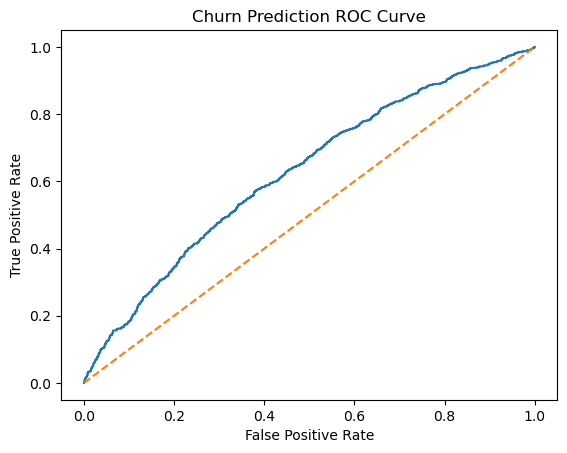

In [28]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Churn Prediction ROC Curve")
plt.show()

## Confusion Matrix

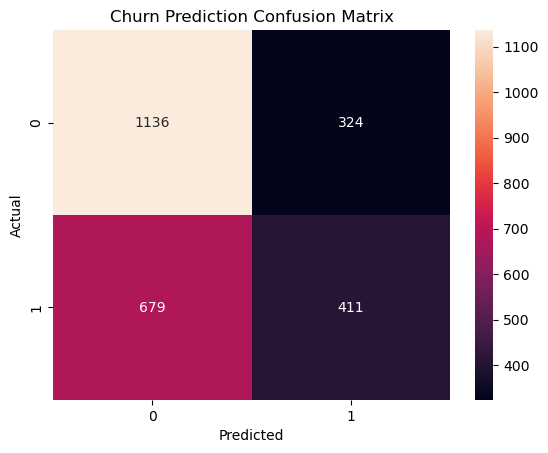

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Churn Prediction Confusion Matrix")
plt.show()

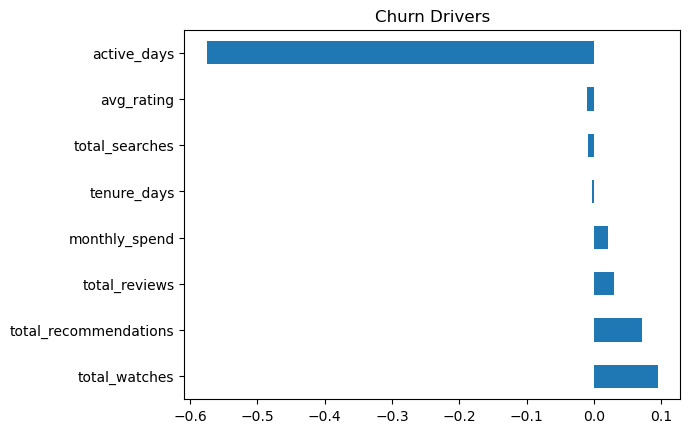

In [30]:
importance.plot(kind="barh", title="Churn Drivers")
plt.show()

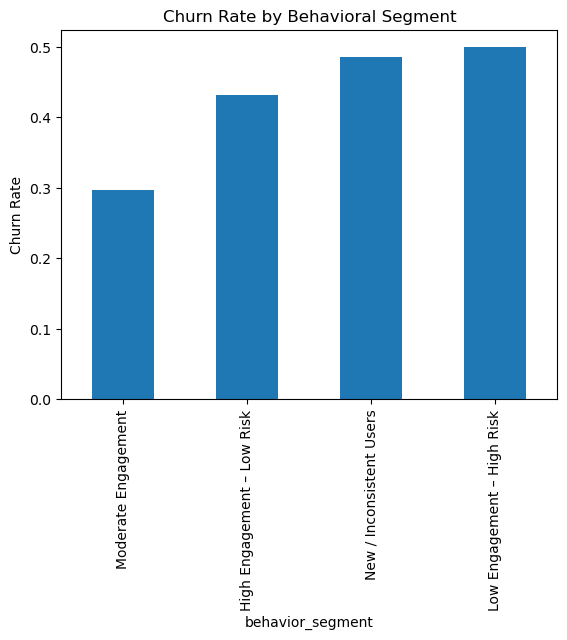

In [31]:
df.groupby("behavior_segment")["churn"].mean().sort_values().plot(kind="bar")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Behavioral Segment")
plt.show()

In [33]:
df.columns

Index(['user_id', 'country', 'subscription_plan', 'subscription_start_date',
       'monthly_spend', 'is_active', 'primary_device', 'created_at',
       'total_watches', 'active_days', 'last_watch_date', 'total_reviews',
       'avg_rating', 'total_searches', 'last_search_date',
       'total_recommendations', 'days_since_last_watch', 'churn',
       'tenure_days', 'behavior_cluster', 'behavior_segment',
       'churn_probability', 'churn_risk_level'],
      dtype='object')

In [34]:
df["engagement_score"] = (
    df["total_watches"] +
    df["active_days"] +
    df["total_searches"]
)

In [35]:
df["churn_probability"] = model.predict_proba(X_scaled)[:, 1]

df["churn_risk_level"] = pd.cut(
    df["churn_probability"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low", "Medium", "High"]
)

In [36]:
df["behavior_segment"] = df["behavior_cluster"].map({
    0: "High Engagement – Low Risk",
    1: "Low Engagement – High Risk",
    2: "Moderate Engagement",
    3: "New / Inconsistent Users"
})

In [37]:
ml_showcase = df[[
    "user_id",
    "behavior_segment",
    "churn_probability",
    "churn_risk_level",
    "engagement_score",
    "monthly_spend"
]]

ml_showcase.head(10)

,user_id,behavior_segment,churn_probability,churn_risk_level,engagement_score,monthly_spend
0,user_00001,Moderate Engagement,0.331410,Medium,26.0,36.06
1,user_00002,Moderate Engagement,0.258291,Low,32.0,14.59
2,user_00003,Low Engagement – High Risk,0.507037,Medium,17.0,11.71
3,user_00004,High Engagement – Low Risk,0.287658,Low,31.0,28.56
4,user_00005,High Engagement – Low Risk,0.441312,Medium,21.0,9.54
5,user_00006,High Engagement – Low Risk,0.405287,Medium,24.0,13.53
6,user_00007,Moderate Engagement,0.327728,Medium,26.0,27.74
7,user_00008,Low Engagement – High Risk,0.352216,Medium,24.0,6.69
8,user_00009,New / Inconsistent Users,0.526583,Medium,16.0,12.21
9,user_00010,High Engagement – Low Risk,0.508007,Medium,20.0,23.18
